In [2]:
# base data sci libraries
import os
import pywt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.filters import gabor_kernel
from sklearn.cluster import KMeans
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.stats import moment

# image processing libraries
import cv2
from PIL import Image
from scipy import ndimage

# sklearn for pipeline creation and grid-search cv
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


# BELOW ONLY NEEDED IF WE GO WITH THE IMPLEMENTATION OF A CNN, BUT I THINK THAT WOULD BE OVER THE TOP FOR THIS TASK
# ! pip install tensorflow
# import tensorflow as tf
# from tensorflow.keras import layers, models

np.random.seed(23)
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
sns.set()

### To-Dos
* Run PCA on existing features 
* Finalize feature selections & tune features
* Once we have features, tweak and play with the grid-search CV to get some baseline results for our model
* Pickle the feature df

### Done
* Add feature functions into cell with extract_log_features() mimicking the format and the instructions there
* Update parse_data() to include any features generated from the functions defined in the featurize block
* Add PCA and any other data exploration we want to complete for feature selection
* Decide on strategy in terms of flattening images or using scalar features -- what is worth spending computational umph on based on data exploration? - NO


### FEATURIZE

We need to translate the features we have already created + those in the proposal + those in the dataset paper into features that are either scalars to be appended to the image vector or a vector of features that can be concatenated onto the end of the feature vector.

Below I have created a formula which defaults to producing a scalar representation of the Laplacian of Gaussian filter. You could also run the filter across the image and then flatten the resulting LoG filtered matrix into a vector (more computationally intensive). This function can be used as a template for the development of other feature formulae to be included in the df creation in the parse_data() function.

##### ERIN TO DO - remember how to use pandas pipeline so we can pass these functions as arguments into parse_data() instead of entering them manually


In [3]:
def extract_log_features(image_array, sigma=0.7, scalar=True):
    """
    Extract Laplacian of Gaussian (LoG) features from an image array.
    
    Parameters:
        image_array (numpy.ndarray): The input image array.
        sigma (float): The sigma value for the Gaussian filter. Controls the amount of smoothing.
        
    Returns:
        numpy.ndarray: The LoG filtered image as a feature vector.
    """
    # apply Laplacian of Gaussian filter
    log_image = ndimage.gaussian_laplace(image_array, sigma=sigma)

    if scalar:
        
        # OPTION 1
        
        # feature scalar: the sum of absolute values in the LoG image (a simple measure of edginess)
        feature_scalar = np.sum(np.abs(log_image))

        return feature_scalar

    else:
        # OPTION 2
        
        # feature vector: flatten the LoG image to use as a feature vector directly
        feature_vector = log_image.flatten()

        return feature_vector

In [4]:
# NOTE: Adjusted HOG so we could return other scalar stats in addition to mean if we want to 
def extract_hog_features(image_array, orientation, pixels, scalar=True):
    """
    Extract HOG features from an image array.
    
    Parameters:
        image_array (numpy.ndarray): The input image array.
        saclar: if the output must be a scalar or a feature vector
        
    Returns:
        numpy.ndarray: The HOG as a list of scalars or a feature vector.
    """
    #preprocessing
    # convert to floating point image with intensity [0, 1]
    if np.max(image_array) > 1:
        img = image_array.astype(np.float32) / 255.0
    # convert to grayscale
    if len(img.shape) > 2:
        img = rgb2gray(img)
    gray_img = img
    #HOG feature extraction
    #the orientation and pixels will increase the detail (more orientations and less pixels are more computationally expensive)
    feature_vector = hog(gray_img, orientations=orientation, pixels_per_cell=(pixels, pixels), visualize=False, feature_vector=True)  
    if scalar:
        feature_scalar_ls = []
        feature_scalar_ls.extend([np.mean(feature_vector), #np.mean is for averaging features
                               np.sum(feature_vector), # Overall "strength" or "intensity" of the features
                               np.var(feature_vector),  # Variance
                               moment(feature_vector, moment=3), # Skewness
                               moment(feature_vector, moment=4)]) # Kurtosis
                
        return feature_scalar_ls
    else:
        return feature_vector

In [5]:
def extract_normals_features(image_array, scalar=True):
    #preprocessing
    # convert to floating point image with intensity [0, 1]
    if np.max(image_array) > 1:
        img = image_array.astype(np.float32) / 255.0
    # convert to grayscale
    if len(img.shape) > 2:
        img = rgb2gray(img)
    gray_img = img
    # Compute gradients using Sobel operator
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)

    # Compute normal vectors Nx, Ny, Nz
    norm = np.sqrt(sobel_x**2 + sobel_y**2 + 1e-6)
    nx = sobel_x / norm
    ny = sobel_y / norm
    nz = 1 / norm

    # Concatenate nx, ny, nz along a new axis, and flatten it to form a 1D feature vector
    feature_vector = np.stack((nx, ny, nz), axis=-1).reshape(-1)
    if scalar:
        feature_scalar = np.sum(feature_vector)
        return feature_scalar
    else:
        return feature_vector

In [6]:
# More on Gabor: https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97

def extract_gabor_features(image_array, frequency=0.6, theta=0, sigma=1.0, scalar=True):
    """
    Extract Gabor features from an image array.

    Parameters:
        image_array (numpy.ndarray): Input image array.
        frequency (float): Controls width of strips of Gabor function. Decreasing wavelength produces thinner stripes
        theta (float): Orientation of the Gabor kernel in radians.
        sigma (float): Standard deviation of kernel in both x and y directions (isotropic).

    Returns:
        numpy.ndarray: Gabor-filtered image as a feature (scalar or vector).
    """
    # Create Gabor kernel
    kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)) # NOTE: Adjust sigma_x or sigma_y if want anisotropic

    # Apply Gabor kernel to image
    gabor_image = np.abs(ndimage.convolve(image_array, kernel, mode='wrap'))

    if scalar:
        # OPTION 1
        # Feature scalar: sum of values in Gabor filtered image
        feature_scalar = np.sum(gabor_image)
        return feature_scalar
    else:
        # OPTION 2
        # Feature vector: flatten Gabor filtered image to use as feature vector directly
        feature_vector = gabor_image.flatten()
        return feature_vector

In [7]:
# More on BoVW: https://rlrocha.medium.com/bag-of-visual-words-applied-to-image-classification-64a7de0b6369
# And Pyramid Histogram of Visual Words: https://slazebni.cs.illinois.edu/publications/pyramid_chapter.pdf

def extract_bovw_features(image_array, n_clusters=5, scalar=True):    
    """
    Extract Bag of Visual Words (BoVW) features from an image array.

    Parameters:
    image_array (numpy.ndarray): Input image array.
    codebook (numpy.ndarray): Visual vocabulary for quantization.
    patch_size (tuple): Size of the image patches to extract (height, width).

    Returns:
    numpy.ndarray: BoVW representation as a feature (scalar or vector).
    """
    # Detect and compute local features w/ SIFT
    
    detector = cv2.SIFT_create()
    keypoints, descriptors = detector.detectAndCompute(image_array, None)

    if descriptors is None:
        # Handle case when no keypoints are detected
        if scalar:
            return 0
        else:
            return np.zeros(n_clusters)

    # Create visual vocabulary (codebook)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(descriptors)
    codebook = kmeans.cluster_centers_

    # Quantize local features to nearest visual word
    labels = kmeans.predict(descriptors)

    # Create BoVW histogram
    bovw_hist, _ = np.histogram(labels, bins=np.arange(n_clusters + 1), density=True)

    if scalar:
        # OPTION 1
        # Feature scalar: sum of values in the BoVW histogram
        feature_scalar = np.sum(bovw_hist)
        return feature_scalar
    else:
        # OPTION 2
        # Feature vector: BoVW histogram
        feature_vector = bovw_hist
        return feature_vector

In [8]:
# More on Wavelet: https://medium.com/@shouke.wei/basic-concepts-of-wavelets-transform-43830a68ac34

def extract_wavelet_features(image_array, wavelet='haar', level=1, scalar=True):
    """
    Extract wavelet transform features from image array.
    
    Parameters:
        image_array (numpy.ndarray): Input image array.
        wavelet (str): Type of wavelet to be used. 
            Doc: https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html
            And: https://pywavelets.readthedocs.io/en/latest/regression/wavelet.html
        level (int): Level of decomposition in wavelet transform.
        
    Returns:
        numpy.ndarray: Wavelet feature as a vector or scalar.
    """
    # apply wavelet transform
    coeffs = pywt.wavedec2(image_array, wavelet, level=level)

    if scalar:
        # compute mean, variance, skewness, and kurtosis from wavelet coefficients
        cA, cD = coeffs[0], coeffs[1:]
        feature_scalar_ls = []
        feature_scalar_ls.extend([np.mean(cA), np.var(cA), np.mean(cD), np.var(cD)])
        

        return feature_scalar_ls
    else:
        # return wavelet coefficients as a flattened feature vector
        feature_vector = np.concatenate([c.flatten() for c in coeffs])
        return feature_vector


In essence, each image needs to be represented as a feature vector. In the D200 example, the photos of the clothing items were in grayscale and then normalized and then reshaped using `train_images_vectors = np.reshape(train_images, (len(train_images), -1))` where train images is an array of n 28 x 28 training images (i.e. train_images.shape = (n, 28, 28)). After each image is reshaped, the vector is 1 x 784 (i.e. 28 x 28).

We need a dataframe at the end of the day, where each row represents an image and its features. I want to talk more about which features we are actually going to leverage and use as a team, but for right now, I will build the plumbing to be able to run a classification once we actually have the features using the 'full image' technique employed in D200. In our case the images are still 200 x 200.

### Parse Data to DF + Add In Features

In [9]:
def parse_data(folder_path):
    image_vectors = []  # image data
    labels = []  # labels
    ids = []  # unique IDs
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            parts = filename.split('_')
            fabType = parts[0]
            id1 = parts[1]
            id2 = parts[3].split('.')[0]  # Remove .png extension
            
            unique_id = id1 + id2

            img = Image.open(os.path.join(folder_path, filename)).convert('L')
            img_array = np.array(img)
            
            # normalize the image vector to be between 0 and 1
            img_vector_normalized = img_array.flatten() / 255.0
            
            image_vectors.append(img_vector_normalized)
            labels.append(fabType)
            ids.append(unique_id)

    X = np.array(image_vectors)
    Y = np.array(labels)
    unique_ids = np.array(ids)
    return X, Y, unique_ids

In [10]:
def parse_all(folder_path):
    image_vectors = []  # image data
    labels = []  # labels
    ids = []  # unique IDs
    features = []

    for filename in os.listdir(folder_path)[:100]: #TODO limited # of images rn 
        if filename.endswith(".png"):
            parts = filename.split('_')
            fabType = parts[0]
            id1 = parts[1]
            id2 = parts[3].split('.')[0]  # Remove .png extension
            
            unique_id = id1 + id2

            img = Image.open(os.path.join(folder_path, filename)).convert('L')
            img_array = np.array(img)
            
            # normalize the image vector to be between 0 and 1
            img_vector_normalized = img_array.flatten() / 255.0

            ### SCALAR FEATURES ###
            hog_stats = extract_hog_features(img_array, 4, 20)
            hog_mean, hog_sum, hog_var, hog_skew, hog_kurt = hog_stats[:5]
            wavelet_stats = extract_wavelet_features(img_array)
            wave_mean_cA, wave_var_cA, wave_mean_cD, wave_var_cD = wavelet_stats[:4]
            
            scalar_features = []
            scalar_features.extend([
                            extract_log_features(img_array),    
                            extract_normals_features(img_array), 
                            extract_gabor_features(img_array),
                            hog_mean, hog_sum, hog_var, hog_skew, hog_kurt,
                            wave_mean_cA, wave_var_cA, wave_mean_cD, wave_var_cD
                            ])
            
            scalar_features_array = np.array(scalar_features)

            """ TODO - Delete?? 
            ------>>>
            # new_vector_with_scalar = np.append(img_vector_normalized, log_scalar)

            ### VECTORIZED FEATURES ###
            # log_vector = extract_log_features(img_array, scalar=False)
            # hog_vector = extract_hog_features(img_array, 4, 20, scalar=False)
            # normals_vector = extract_normals_features(img_array, scalar = False)
            
            #NOTE: This is created but then not used, I added as an additional output (features)  
            # final_img_feature_vector  = np.concatenate((img_vector_normalized, scalar_features_array, log_vector, hog_vector, normals_vector)) # BE SURE TO ADD ANY FEATURE VECTORS HERE
            <<<-----   
            """
            final_img_feature_vector  = np.concatenate((img_vector_normalized, scalar_features_array)) # Scalars only 

            image_vectors.append(img_vector_normalized)
            labels.append(fabType)
            ids.append(unique_id)
            features.append(final_img_feature_vector)

    X = np.array(image_vectors)
    Y = np.array(labels)
    unique_ids = np.array(ids)
    features_array = np.array(features)
    return X, Y, unique_ids, features_array

Note - the cell below takes ~25 seconds to run on my mac. It may take a bit longer depending on your processing power and memory. If this becomes an issue, we can save the dataframe it creates as a pickle file, which could be saved to sub-samples and you two would be able to use without issue i.e. my computer processes and adds features and then saves it as a compressed python binary to allow for easy access that avoids double processing later. Just let me know if we need to do that!

Note 2 - After adding HOG and Normals features, it took 4 m 4.2 sec in my computer, the second time broke, so I created a code that is only to create the df. The original one + the 2 additional features is in parse_all

In [28]:
# PARSE ALL 
folder_path = './Subsamples/train'
X, Y, unique_ids, features_array = parse_all(folder_path)

df = pd.DataFrame(X)
df['category'] = pd.Categorical(Y)
df['label'], _ = pd.factorize(df['category'])
df['uid'] = unique_ids
df.head()

,0,1,2,3,4,5,6,7,8,9,...,39993,39994,39995,39996,39997,39998,39999,category,label,uid
0,0.062745,0.058824,0.066667,0.062745,0.062745,0.066667,0.082353,0.086275,0.101961,0.101961,...,0.066667,0.058824,0.054902,0.054902,0.058824,0.062745,0.062745,Blended,0,8821c
1,0.266667,0.258824,0.270588,0.301961,0.313725,0.352941,0.439216,0.478431,0.572549,0.607843,...,0.200000,0.333333,0.749020,0.803922,0.788235,0.760784,0.717647,Denim,1,1503c
2,0.235294,0.247059,0.274510,0.298039,0.309804,0.305882,0.282353,0.274510,0.270588,0.258824,...,0.168627,0.133333,0.125490,0.133333,0.160784,0.192157,0.211765,Polyester,2,16132c
3,0.380392,0.364706,0.356863,0.345098,0.341176,0.345098,0.388235,0.435294,0.450980,0.423529,...,0.400000,0.415686,0.450980,0.482353,0.482353,0.505882,0.545098,Blended,0,3621d
4,0.321569,0.317647,0.305882,0.298039,0.294118,0.301961,0.309804,0.313725,0.325490,0.333333,...,0.376471,0.298039,0.247059,0.278431,0.345098,0.333333,0.309804,Cotton,3,2333a


In [11]:
# PARSE DATA 
folder_path = './Subsamples/train'
X, Y, unique_ids = parse_data(folder_path)

df = pd.DataFrame(X)
df['category'] = pd.Categorical(Y)
df['label'], _ = pd.factorize(df['category'])
df['uid'] = unique_ids
df.head()

,0,1,2,3,4,5,6,7,8,9,...,39993,39994,39995,39996,39997,39998,39999,category,label,uid
0,0.062745,0.058824,0.066667,0.062745,0.062745,0.066667,0.082353,0.086275,0.101961,0.101961,...,0.066667,0.058824,0.054902,0.054902,0.058824,0.062745,0.062745,Blended,0,8821c
1,0.266667,0.258824,0.270588,0.301961,0.313725,0.352941,0.439216,0.478431,0.572549,0.607843,...,0.200000,0.333333,0.749020,0.803922,0.788235,0.760784,0.717647,Denim,1,1503c
2,0.235294,0.247059,0.274510,0.298039,0.309804,0.305882,0.282353,0.274510,0.270588,0.258824,...,0.168627,0.133333,0.125490,0.133333,0.160784,0.192157,0.211765,Polyester,2,16132c
3,0.380392,0.364706,0.356863,0.345098,0.341176,0.345098,0.388235,0.435294,0.450980,0.423529,...,0.400000,0.415686,0.450980,0.482353,0.482353,0.505882,0.545098,Blended,0,3621d
4,0.321569,0.317647,0.305882,0.298039,0.294118,0.301961,0.309804,0.313725,0.325490,0.333333,...,0.376471,0.298039,0.247059,0.278431,0.345098,0.333333,0.309804,Cotton,3,2333a


With this dataframe, which is in the same format as the data shown in the MNIST D200 homework, it should be easy to set up t-SNE and PCA. HOWEVER - at this point we don't have any true features, as our existing features need to be converted to columns in this dataframe. Below is skeleton code that can be filled out to run and add these features

### TO DO - INSERT PCA AND OTHER EDA

In [12]:
#reorder 
train_df = df
train_df.columns = train_df.columns.astype(str)
PIXEL_COLS = train_df.columns.tolist()[:-3] # list of pixel header
LABEL_COLS = ['label', 'category'] # list of labels header

cols_reorder = LABEL_COLS + PIXEL_COLS
train_df = train_df[cols_reorder]
train_df.head()

,label,category,0,1,2,3,4,5,6,7,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,0,Blended,0.062745,0.058824,0.066667,0.062745,0.062745,0.066667,0.082353,0.086275,...,0.086275,0.082353,0.070588,0.066667,0.058824,0.054902,0.054902,0.058824,0.062745,0.062745
1,1,Denim,0.266667,0.258824,0.270588,0.301961,0.313725,0.352941,0.439216,0.478431,...,0.164706,0.149020,0.176471,0.200000,0.333333,0.749020,0.803922,0.788235,0.760784,0.717647
2,2,Polyester,0.235294,0.247059,0.274510,0.298039,0.309804,0.305882,0.282353,0.274510,...,0.160784,0.180392,0.160784,0.168627,0.133333,0.125490,0.133333,0.160784,0.192157,0.211765
3,0,Blended,0.380392,0.364706,0.356863,0.345098,0.341176,0.345098,0.388235,0.435294,...,0.270588,0.270588,0.305882,0.400000,0.415686,0.450980,0.482353,0.482353,0.505882,0.545098
4,3,Cotton,0.321569,0.317647,0.305882,0.298039,0.294118,0.301961,0.309804,0.313725,...,0.576471,0.462745,0.411765,0.376471,0.298039,0.247059,0.278431,0.345098,0.333333,0.309804


In [13]:
#choose  a sample of the data to see if works:
# Sample data
sampled_train_df = train_df.sample(frac=0.2)


In [14]:
sampled_train_df

,label,category,0,1,2,3,4,5,6,7,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
20691,4,Wool,0.976471,0.976471,0.972549,0.976471,0.976471,0.980392,0.984314,0.984314,...,0.764706,0.741176,0.721569,0.701961,0.666667,0.635294,0.627451,0.611765,0.611765,0.611765
10644,4,Wool,0.368627,0.368627,0.333333,0.309804,0.313725,0.349020,0.356863,0.329412,...,0.356863,0.321569,0.278431,0.266667,0.266667,0.274510,0.278431,0.294118,0.294118,0.294118
10333,2,Polyester,0.568627,0.560784,0.556863,0.513725,0.474510,0.470588,0.498039,0.525490,...,0.454902,0.447059,0.443137,0.439216,0.435294,0.431373,0.443137,0.450980,0.474510,0.490196
10858,1,Denim,0.145098,0.133333,0.086275,0.070588,0.066667,0.062745,0.058824,0.058824,...,0.188235,0.219608,0.231373,0.231373,0.239216,0.231373,0.231373,0.227451,0.196078,0.180392
9757,0,Blended,0.415686,0.411765,0.423529,0.435294,0.423529,0.360784,0.309804,0.298039,...,0.462745,0.482353,0.482353,0.482353,0.490196,0.474510,0.470588,0.447059,0.494118,0.505882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,4,Wool,0.125490,0.094118,0.070588,0.070588,0.074510,0.078431,0.074510,0.082353,...,0.556863,0.454902,0.372549,0.337255,0.262745,0.184314,0.160784,0.149020,0.160784,0.184314
10101,3,Cotton,0.800000,0.803922,0.796078,0.792157,0.792157,0.792157,0.788235,0.792157,...,0.729412,0.705882,0.713725,0.717647,0.737255,0.764706,0.772549,0.807843,0.858824,0.882353
6574,1,Denim,0.470588,0.450980,0.388235,0.360784,0.368627,0.392157,0.423529,0.443137,...,0.431373,0.458824,0.490196,0.568627,0.694118,0.603922,0.552941,0.490196,0.439216,0.435294
8549,3,Cotton,0.113725,0.090196,0.086275,0.078431,0.090196,0.105882,0.152941,0.125490,...,0.164706,0.164706,0.164706,0.160784,0.152941,0.156863,0.149020,0.145098,0.156863,0.160784


In [19]:
#PCA (From data 200 code, lecture-26) - This is too heavy to run
n_comps = 100
PCA_COLS = [f"pc{i+1}" for i in range(n_comps)]
pca = PCA(n_components=n_comps)
pca.fit(sampled_train_df[PIXEL_COLS])
principal_components = pca.transform(sampled_train_df[PIXEL_COLS])

In [20]:
np.sum(pca.explained_variance_ratio_)

0.9055491486444824

In [21]:
# PC1, PC2 component scores
np.sum(pca.explained_variance_ratio_[:2])

0.8421972428877974

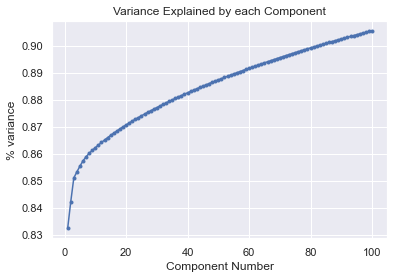

In [23]:
variances = pca.explained_variance_ratio_

cumulatives = [] 

for i in range(len(variances)):
    if i == 0:
        cumulative = variances[i]  # For the first element, cumulative sum is the variance itself
    else:
        cumulative += variances[i]  # Accumulate the current variance to the previous cumulative sum
    cumulatives.append(cumulative)

cumulatives
# plot the explained variance (here we have to do it in the opposite side)
plt.plot(np.arange(n_comps)+1,
         cumulatives,
         marker='.');
plt.ylabel("% variance")
plt.xlabel("Component Number")
plt.title("Variance Explained by each Component")
plt.show()

In [25]:
#PCA (From data 200 code, lecture-26) - This is too heavy to run
n_comps = 20
PCA_COLS = [f"pc{i+1}" for i in range(n_comps)]
pca2 = PCA(n_components=n_comps)
pca2.fit(train_df[PIXEL_COLS])
principal_components_2 = pca2.transform(train_df[PIXEL_COLS])

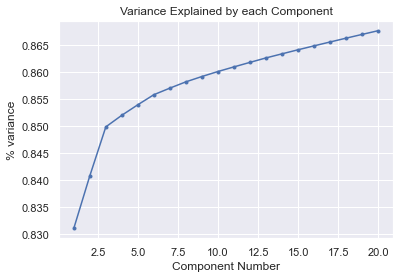

In [26]:
variances = pca2.explained_variance_ratio_

cumulatives = [] 

for i in range(len(variances)):
    if i == 0:
        cumulative = variances[i]  # For the first element, cumulative sum is the variance itself
    else:
        cumulative += variances[i]  # Accumulate the current variance to the previous cumulative sum
    cumulatives.append(cumulative)

cumulatives
# plot the explained variance (here we have to do it in the opposite side)
plt.plot(np.arange(n_comps)+1,
         cumulatives,
         marker='.');
plt.ylabel("% variance")
plt.xlabel("Component Number")
plt.title("Variance Explained by each Component")
plt.show()

In [47]:
def extract_scalar(folder_path):
    scalars = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img = Image.open(os.path.join(folder_path, filename)).convert('L')
            img_array = np.array(img)
            
            ### SCALAR FEATURES ###
            hog_stats = extract_hog_features(img_array, 4, 20)
            hog_mean, hog_sum, hog_var, hog_skew, hog_kurt = hog_stats[:5]
            wavelet_stats = extract_wavelet_features(img_array)
            wave_mean_cA, wave_var_cA, wave_mean_cD, wave_var_cD = wavelet_stats[:4]
            
            scalar_features = []
            scalar_features.extend([
                            extract_log_features(img_array),    
                            extract_normals_features(img_array), 
                            extract_gabor_features(img_array),
                            hog_mean, hog_sum, hog_var, hog_skew, hog_kurt,
                            wave_mean_cA, wave_var_cA, wave_mean_cD, wave_var_cD
                            ])


            scalars.append(scalar_features)
    return scalars

In [48]:
folder_path = './Subsamples/train'
scalars_features = extract_scalar(folder_path)

In [54]:
scalars_array = np.array(scalars_features)
scalars_df = pd.DataFrame(scalars_array)
scalars_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,4084582.0,848125.481865,250793.0,0.150290,346.268127,0.005191,0.000090,0.000063,188.70860,19587.608386,0.100800,66.292873
1,5083084.0,188153.935541,475839.0,0.151459,348.960510,0.004838,-0.000069,0.000038,245.86870,10136.469710,-0.030100,118.415777
2,4591326.0,469947.845153,84792.0,0.160472,369.726685,0.002027,-0.000002,0.000008,92.02735,853.668027,0.030550,14.026042
3,4976703.0,353395.602580,216421.0,0.152294,350.886292,0.004584,0.000015,0.000034,242.57325,2894.154259,0.014783,30.088056
4,4834379.0,310404.673397,217692.0,0.157962,363.943604,0.002826,0.000002,0.000017,183.02350,2864.363798,-0.051767,40.247404


In [57]:
#PCA over scalars features
n_comps = 11
pca_scalar = PCA(n_components=n_comps)
pca_scalar.fit(scalars_df)
principal_components_2 = pca_scalar.transform(scalars_df)



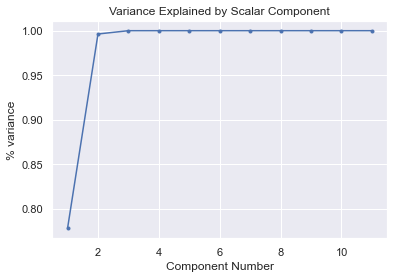

In [59]:
variances = pca_scalar.explained_variance_ratio_

cumulatives = [] 

for i in range(len(variances)):
    if i == 0:
        cumulative = variances[i]  # For the first element, cumulative sum is the variance itself
    else:
        cumulative += variances[i]  # Accumulate the current variance to the previous cumulative sum
    cumulatives.append(cumulative)

cumulatives
# plot the explained variance (here we have to do it in the opposite side)
plt.plot(np.arange(n_comps)+1,
         cumulatives,
         marker='.');
plt.ylabel("% variance")
plt.xlabel("Component Number")
plt.title("Variance Explained by Scalar Component")
plt.show()

### SVM - Multi-Class Classifier


The function below takes in a test DF, features (which we can modified in the event we have thousands of columns and they are named numerically -- in this case we just need to drop the target variable to define X). It runs cross validation to determine the best hyperparameters to be used for the support vector machine model, returning a grid search object with the following attributes (per ChatGPT):

<b>Attributes</b>
* best_estimator_: The estimator that was chosen by the search, i.e., the estimator which gave highest score (or smallest loss if specified) on the left out data. Not available if refit=False.
* best_score_: The score of the best_estimator on the left out data.
* best_params_: The parameter setting that gave the best results on the hold out data.
* best_index_: The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.
* cv_results_: A dictionary with keys as column headers and values as columns, that can be imported into a pandas DataFrame. This attribute provides scores, fit times, score times, and parameters for all the candidate models. It contains a lot of detailed information for each parameter combination that was evaluated.
* scorer_: The function or a dictionary of functions that scores the predictions on the test set.
* n_splits_: The number of cross-validation splits (folds/iterations).
* refit_time_: Time for refitting the best estimator on the whole dataset (available only if refit is set to True).

<b>Methods</b>
* fit(X, y=None, groups=None): Run fit with all sets of parameters.
* predict(X): Call predict on the estimator with the best found parameters.
* score(X, y=None): Returns the score on the given data, if the estimator has been refit.
* predict_proba(X): Call predict_proba on the estimator with the best found parameters, if available.
* decision_function(X): Call decision_function on the estimator with the best found parameters, if available.
* transform(X): Call transform on the estimator with the best found parameters, if available.
* inverse_transform(X): Call inverse_transform on the estimator with the best found parameters, if available.

In [27]:
def svm_grid_search_cv(dataframe, features, target, cv_folds=5):
    """
    Perform grid search cross-validation for SVM classifier on the given dataframe.
    
    Parameters:
    - dataframe: The pandas DataFrame containing the dataset.
    - features: List of column names to be used as features.
    - target: The name of the column to be used as the target variable.
    - cv_folds: Number of folds for cross-validation.
    
    Returns:
    - grid_search: The fitted GridSearchCV object.
    """
    
    # Separate the features and the target variable
    X = dataframe[features]
    y = dataframe[target]
    
    # Split the data into training and testing sets (optional, could also perform CV on the entire dataset)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define a pipeline that includes scaling and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling is important for SVM
        ('svm', SVC(probability=True))  # SVM classifier
    ])
    
    # Parameter grid for GridSearchCV
    param_grid = {
        'svm__C': [0.1, 1, 10],  # SVM regularization parameter
        'svm__kernel': ['linear', 'rbf'],  # Kernel type to be used in the algorithm
        'svm__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring='accuracy', verbose=1)
    
    # Perform grid search cross-validation
    grid_search.fit(X_train, y_train)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    
    # Optionally, evaluate on the test set
    test_score = grid_search.score(X_test, y_test)
    print("Test set score: {:.2f}".format(test_score))
    
    return grid_search


### Convolutional Neural Network

The below code has not been tested or debugged - it was read through against a TDS article for accuracy, but it would need significant work, change in approach (and potentially additional compute) if we are to make it work. I wanted to store it so I don't lose the information though!

In [ ]:
# simple cnn model
# def create_cnn_model(input_shape, num_classes):
#     model = models.Sequential([
#         # convolutional layer with ReLU activation and Max Pooling
#         layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#         layers.MaxPooling2D((2, 2)),
        
#         # convolutional layer 2
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.MaxPooling2D((2, 2)),
        
#         # flatten the output and add dense layers for classification
#         layers.Flatten(),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(num_classes, activation='softmax')
#     ])
    
#     return model

# input_shape = (64, 64, 3)  # input shape (height, width, channels)
# num_classes = 5

# model = create_cnn_model(input_shape, num_classes)

# # compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])


# # train_images, train_labels = ... 
# # val_images, val_labels = ... 

# train model
# history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))


In [ ]:
## TO DO - ADD SVM CODE